In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import torch
from torch import nn
from torchvision.models import resnet50, ResNet50_Weights
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
sns.set_theme()
# sns.set_context("paper")
sns.set_style("ticks")

import sys
sys.path.append('./benchmarking-uncertainty-estimation-performance-main/utils')
from uncertainty_metrics import AURC_calc, AUROC, EAURC_calc, ECE_calc, calc_adaptive_bin_size

from cifar10_models.mobilenetv2 import mobilenet_v2
from cifar10_models.vgg import vgg16_bn
from cifar10_models.resnet import resnet50

from utils import load_dataloaders_CIFAR, load_dataloaders_ImageNet

torch.manual_seed(0)
np.random.seed(0)
rng = np.random.default_rng(0)

path_data = Path(os.path.expandvars('$DSDIR/'))
path_results = Path.cwd().parent / 'results'

device = 'cuda:0'

In [2]:
MODEL_ARCHITECTURE = 'VGG'
DATASET = 'CIFAR10'
BATCH_SIZE = 64

In [3]:
# LOAD DATA

if DATASET == 'CIFAR10':
    path_dataset = path_data
    dataloader_train, dataloader_val = load_dataloaders_CIFAR(path_dataset, BATCH_SIZE)
elif DATASET == 'ImageNet':
    path_dataset = path_data + 'IMAGENET'
    dataloader_train, dataloader_val = load_dataloaders_ImageNet(path_dataset, BATCH_SIZE)
    
n_classes = 10#len(dataloader_train.dataset.classes)

In [4]:
# LOAD MODEL

if DATASET == 'CIFAR10':
    if MODEL_ARCHITECTURE == 'VGG':
        classifier = vgg16_bn(pretrained=True).to(device)
        features_extractor = nn.Sequential(*list(classifier.features.children())).to(device)
    elif MODEL_ARCHITECTURE == 'MobileNet':
        classifier = mobilenet_v2(pretrained=True).to(device)
        features_extractor = nn.Sequential(*list(classifier.features.children())).to(device)
    elif MODEL_ARCHITECTURE == 'ResNet':
        classifier = resnet50(pretrained=True).to(device)
        features_extractor = nn.Sequential(*list(classifier.children())[:-1]).to(device)
        
elif DATASET == 'ImageNet':
    weights = ResNet50_Weights.IMAGENET1K_V2
    classifier = resnet50(weights=weights).to(device)
    # preprocess = weights.transforms()
    features_extractor = nn.Sequential(*list(classifier.children())[:-1]).to(device)
    
classifier.eval()
features_extractor.eval();

In [5]:
criterion = nn.CrossEntropyLoss(reduction='none')

features = None
loss = None
correct_pred = None
logits = None
for inputs, labels in dataloader_train:
    inputs = inputs.to(device)
    labels = labels.to(device)
    
    with torch.no_grad():
        features_t = features_extractor(inputs).mean([2, 3]).detach().cpu().numpy() # use hook to avoid 2 forward passes
        logits_t = classifier(inputs)
    class_predictions = logits_t.argmax(dim=1)
    loss_t = criterion(logits_t, labels).detach().cpu().numpy()
    correct_pred_t = (class_predictions == labels).detach().cpu().numpy()
    
    features = features_t if features is None else np.concatenate((features, features_t), axis=0)
    logits_t = logits_t.detach().cpu().numpy()
    logits = logits_t if logits is None else np.concatenate((logits, logits_t), axis=0)
    loss = loss_t if loss is None else np.concatenate((loss, loss_t), axis=0)
    correct_pred = correct_pred_t if correct_pred is None else np.concatenate((correct_pred, correct_pred_t), axis=0)
    
#     if len(logits) > 5000:
#         break
# print(logits.shape)

kmeans = KMeans(n_clusters=n_classes, random_state=0).fit(features)

In [6]:
criterion = nn.CrossEntropyLoss(reduction='none')

features = None
loss = None
correct_pred = None
logits = None
tcp = None
for inputs, labels in dataloader_val:
    inputs = inputs.to(device)
    labels = labels.to(device)
    
    with torch.no_grad():
        features_t = features_extractor(inputs).mean([2, 3]).detach().cpu().numpy() # use hook to avoid 2 forward passes
        logits_t = classifier(inputs)
    class_predictions = logits_t.argmax(dim=1)
    loss_t = criterion(logits_t, labels).detach().cpu().numpy()
    correct_pred_t = (class_predictions == labels).detach().cpu().numpy()

    probas = torch.softmax(logits_t, dim=1)
    tcp_t = probas[torch.nn.functional.one_hot(labels, n_classes).bool()].cpu().numpy()
    
    features = features_t if features is None else np.concatenate((features, features_t), axis=0)
    logits_t = logits_t.detach().cpu().numpy()
    logits = logits_t if logits is None else np.concatenate((logits, logits_t), axis=0)
    loss = loss_t if loss is None else np.concatenate((loss, loss_t), axis=0)
    correct_pred = correct_pred_t if correct_pred is None else np.concatenate((correct_pred, correct_pred_t), axis=0)
    tcp = tcp_t if tcp is None else np.concatenate((tcp, tcp_t), axis=0)

euclidian_dist = kmeans.transform(features).min(axis=1)
cosine_sim = cosine_similarity(features, kmeans.cluster_centers_).max(axis=1)

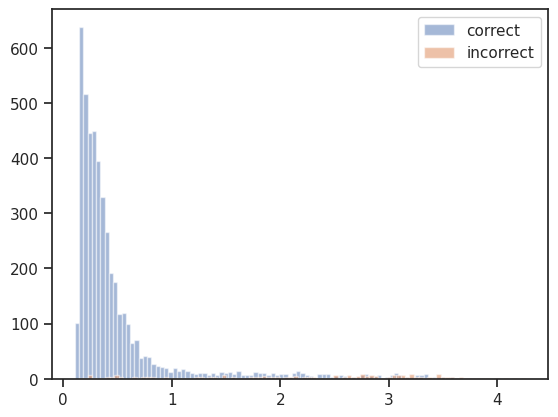

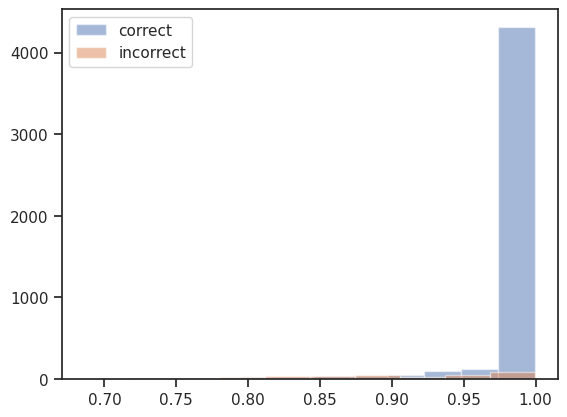

In [7]:
plt.figure()
plt.hist(euclidian_dist[correct_pred], bins=100, alpha=0.5, label='correct')
plt.hist(euclidian_dist[~correct_pred], bins=100, alpha=0.5, label='incorrect')
plt.legend()

plt.figure()
plt.hist(cosine_sim[correct_pred], alpha=0.5, label='correct')
plt.hist(cosine_sim[~correct_pred], alpha=0.5, label='incorrect')
plt.legend()

# plt.figure()
# plt.scatter(euclidian_dist[correct_pred], cosine_sim[correct_pred], alpha=0.5, label='correct')
# plt.scatter(euclidian_dist[~correct_pred], cosine_sim[~correct_pred], alpha=0.5, label='incorrect')
# plt.legend()

# plt.figure()
# plt.scatter(euclidian_dist[correct_pred], loss[correct_pred], alpha=0.5, label='correct')
# plt.scatter(euclidian_dist[~correct_pred], loss[~correct_pred], alpha=0.5, label='incorrect')

# plt.figure()
# plt.scatter(cosine_sim[correct_pred], loss[correct_pred], alpha=0.5, label='correct')
# plt.scatter(cosine_sim[~correct_pred], loss[~correct_pred], alpha=0.5, label='incorrect')

/tmp/ipykernel_1603028/3962565546.py:12: RuntimeWarning: Mean of empty slice.
  acc_baseline[i] = classif_correct[idx_domain].mean()
/gpfslocalsup/pub/anaconda-py3/2023.09/envs/pytorch-gpu-2.2.0+py3.11.7/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1603028/3962565546.py:21: RuntimeWarning: Mean of empty slice.
  acc_cosineSim[i] = classif_correct[idx_domain].mean()
/tmp/ipykernel_1603028/3962565546.py:30: RuntimeWarning: Mean of empty slice.
  acc_eucliDist[i] = classif_correct[idx_domain].mean()
/tmp/ipykernel_1603028/3962565546.py:41: RuntimeWarning: Mean of empty slice.
  acc_baselineTCP[i] = classif_correct[idx_domain].mean()


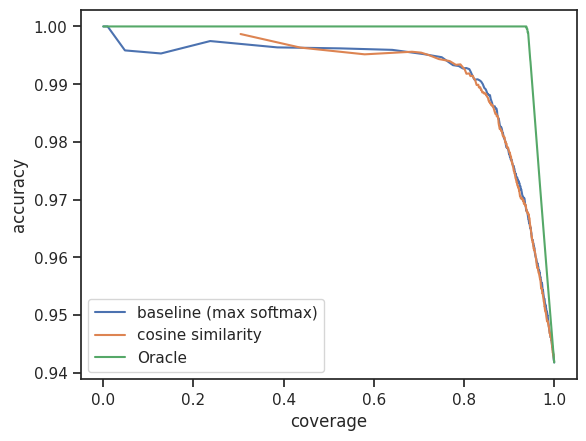

In [8]:
probas = torch.softmax(torch.tensor(logits), dim=1).squeeze()
classif_correct = correct_pred

    
# baseline: max softmax
domain_cutoff_baseline = np.linspace(0, 1, 1000)
coverage_baseline = np.zeros_like(domain_cutoff_baseline)
acc_baseline = np.zeros_like(domain_cutoff_baseline)
for i, cut in enumerate(domain_cutoff_baseline):
    idx_domain = probas.max(dim=1).values > cut
    coverage_baseline[i] = idx_domain.float().mean()
    acc_baseline[i] = classif_correct[idx_domain].mean()

# cosine similarity
domain_cutoff_cosineSim = np.linspace(cosine_sim.min(), cosine_sim.max(), 1000)
coverage_cosineSim = np.zeros_like(domain_cutoff_cosineSim)
acc_cosineSim = np.zeros_like(domain_cutoff_cosineSim)
for i, cut in enumerate(domain_cutoff_cosineSim):
    idx_domain = cosine_sim > cut
    coverage_cosineSim[i] = idx_domain.astype(float).mean()
    acc_cosineSim[i] = classif_correct[idx_domain].mean()
    
# euclidian distance
domain_cutoff_eucliDist = np.linspace(euclidian_dist.min(), euclidian_dist.max(), 1000)
coverage_eucliDist = np.zeros_like(domain_cutoff_eucliDist)
acc_eucliDist = np.zeros_like(domain_cutoff_eucliDist)
for i, cut in enumerate(domain_cutoff_eucliDist):
    idx_domain = euclidian_dist < cut
    coverage_eucliDist[i] = idx_domain.astype(float).mean()
    acc_eucliDist[i] = classif_correct[idx_domain].mean()

# oracle
# total_tcp = torch.softmax(torch.tensor(logits), 1).max(1).values
domain_cutoff_baselineTCP = np.linspace(0, 1, 1000)
coverage_baselineTCP = np.zeros_like(domain_cutoff_baselineTCP)
risk_baselineTCP = np.zeros_like(domain_cutoff_baselineTCP)
acc_baselineTCP = np.zeros_like(domain_cutoff_baselineTCP)
for i, cut in enumerate(domain_cutoff_baselineTCP):
    idx_domain = tcp > cut
    coverage_baselineTCP[i] = idx_domain.mean()
    acc_baselineTCP[i] = classif_correct[idx_domain].mean()

fig, ax = plt.subplots(1, 1)
# ax.set_title('coverage vs. accuracy\n(obtained by varying confidence/uncertainty threshold)')
ax.plot(coverage_baseline, acc_baseline, label='baseline (max softmax)')
ax.plot(coverage_cosineSim, acc_cosineSim, label='cosine similarity')
# ax.plot(coverage_eucliDist, acc_eucliDist, label='euclidian distance')
ax.plot(coverage_baselineTCP, acc_baselineTCP, label='Oracle')
ax.legend()
ax.set_xlabel('coverage')
ax.set_ylabel('accuracy')
plt.savefig(str(path_results / 'selection_function' / (f'kmeans_{MODEL_ARCHITECTURE}.pdf')))

In [9]:
samples_certainties = torch.stack((torch.tensor(cosine_sim), torch.tensor(correct_pred)), dim=1)
print(AUROC(samples_certainties))
print(AURC_calc(samples_certainties))

0.920095977651919
0.007724996473388637


In [10]:
samples_certainties = torch.stack((probas.max(dim=1).values, torch.tensor(correct_pred)), dim=1)
print(AUROC(samples_certainties))
print(AURC_calc(samples_certainties))

0.9215051385845193
0.008183607671226013


In [11]:
AURC_calc

<function uncertainty_metrics.AURC_calc(samples_certainties, sort=True)>